In [20]:
import random
import sys
sys.path.append('..')

import dataloader
import utils
import figures

import pickle5 as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
samples, sample_genes, sample_barcodes = dataloader.load_processed_spots(n_genes=20)
positions = dataloader.load_positions(sample_barcodes, positions_path='../data/spatial/tissue_positions_list.csv')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.var` of view, copying.


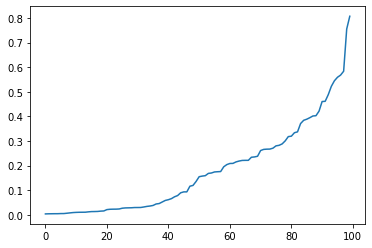

In [35]:
variances = np.var(samples, axis=0).tolist()[0]
variances = np.sort(variances)
plt.plot(variances)

In [37]:
samples.shape, len(sample_genes), len(sample_barcodes)

((2896, 20), 20, 2896)

In [243]:
# get times
timedict = pickle.load(open('../data/pseudo_dist2.pickle', 'rb+'))
times = np.array(list(timedict.keys()))
time_barcodes = np.array(list(timedict.values()))
idx = np.argsort(times)
times = times[idx]
time_barcodes = time_barcodes[idx]
len(timedict)

2889

In [244]:
train_idx = np.zeros(len(times))
train_idx[::2] = 1
train_idx = train_idx.astype(bool)

In [245]:
def make_df(barcode_timeseries):
    time_idx = [sample_barcodes.index(barcode) for barcode in barcode_timeseries]
    df = pd.DataFrame(samples[time_idx], columns=sample_genes)
    return df

train_df = make_df(time_barcodes[train_idx])
test_df = make_df(time_barcodes[~train_idx])

In [246]:
lags = 2
W_dy = utils.learn_dbn(train_df, lags)

In [247]:
true_mse = utils.mse(W_dy, test_df, lags)
true_mse

0.11788088997100157

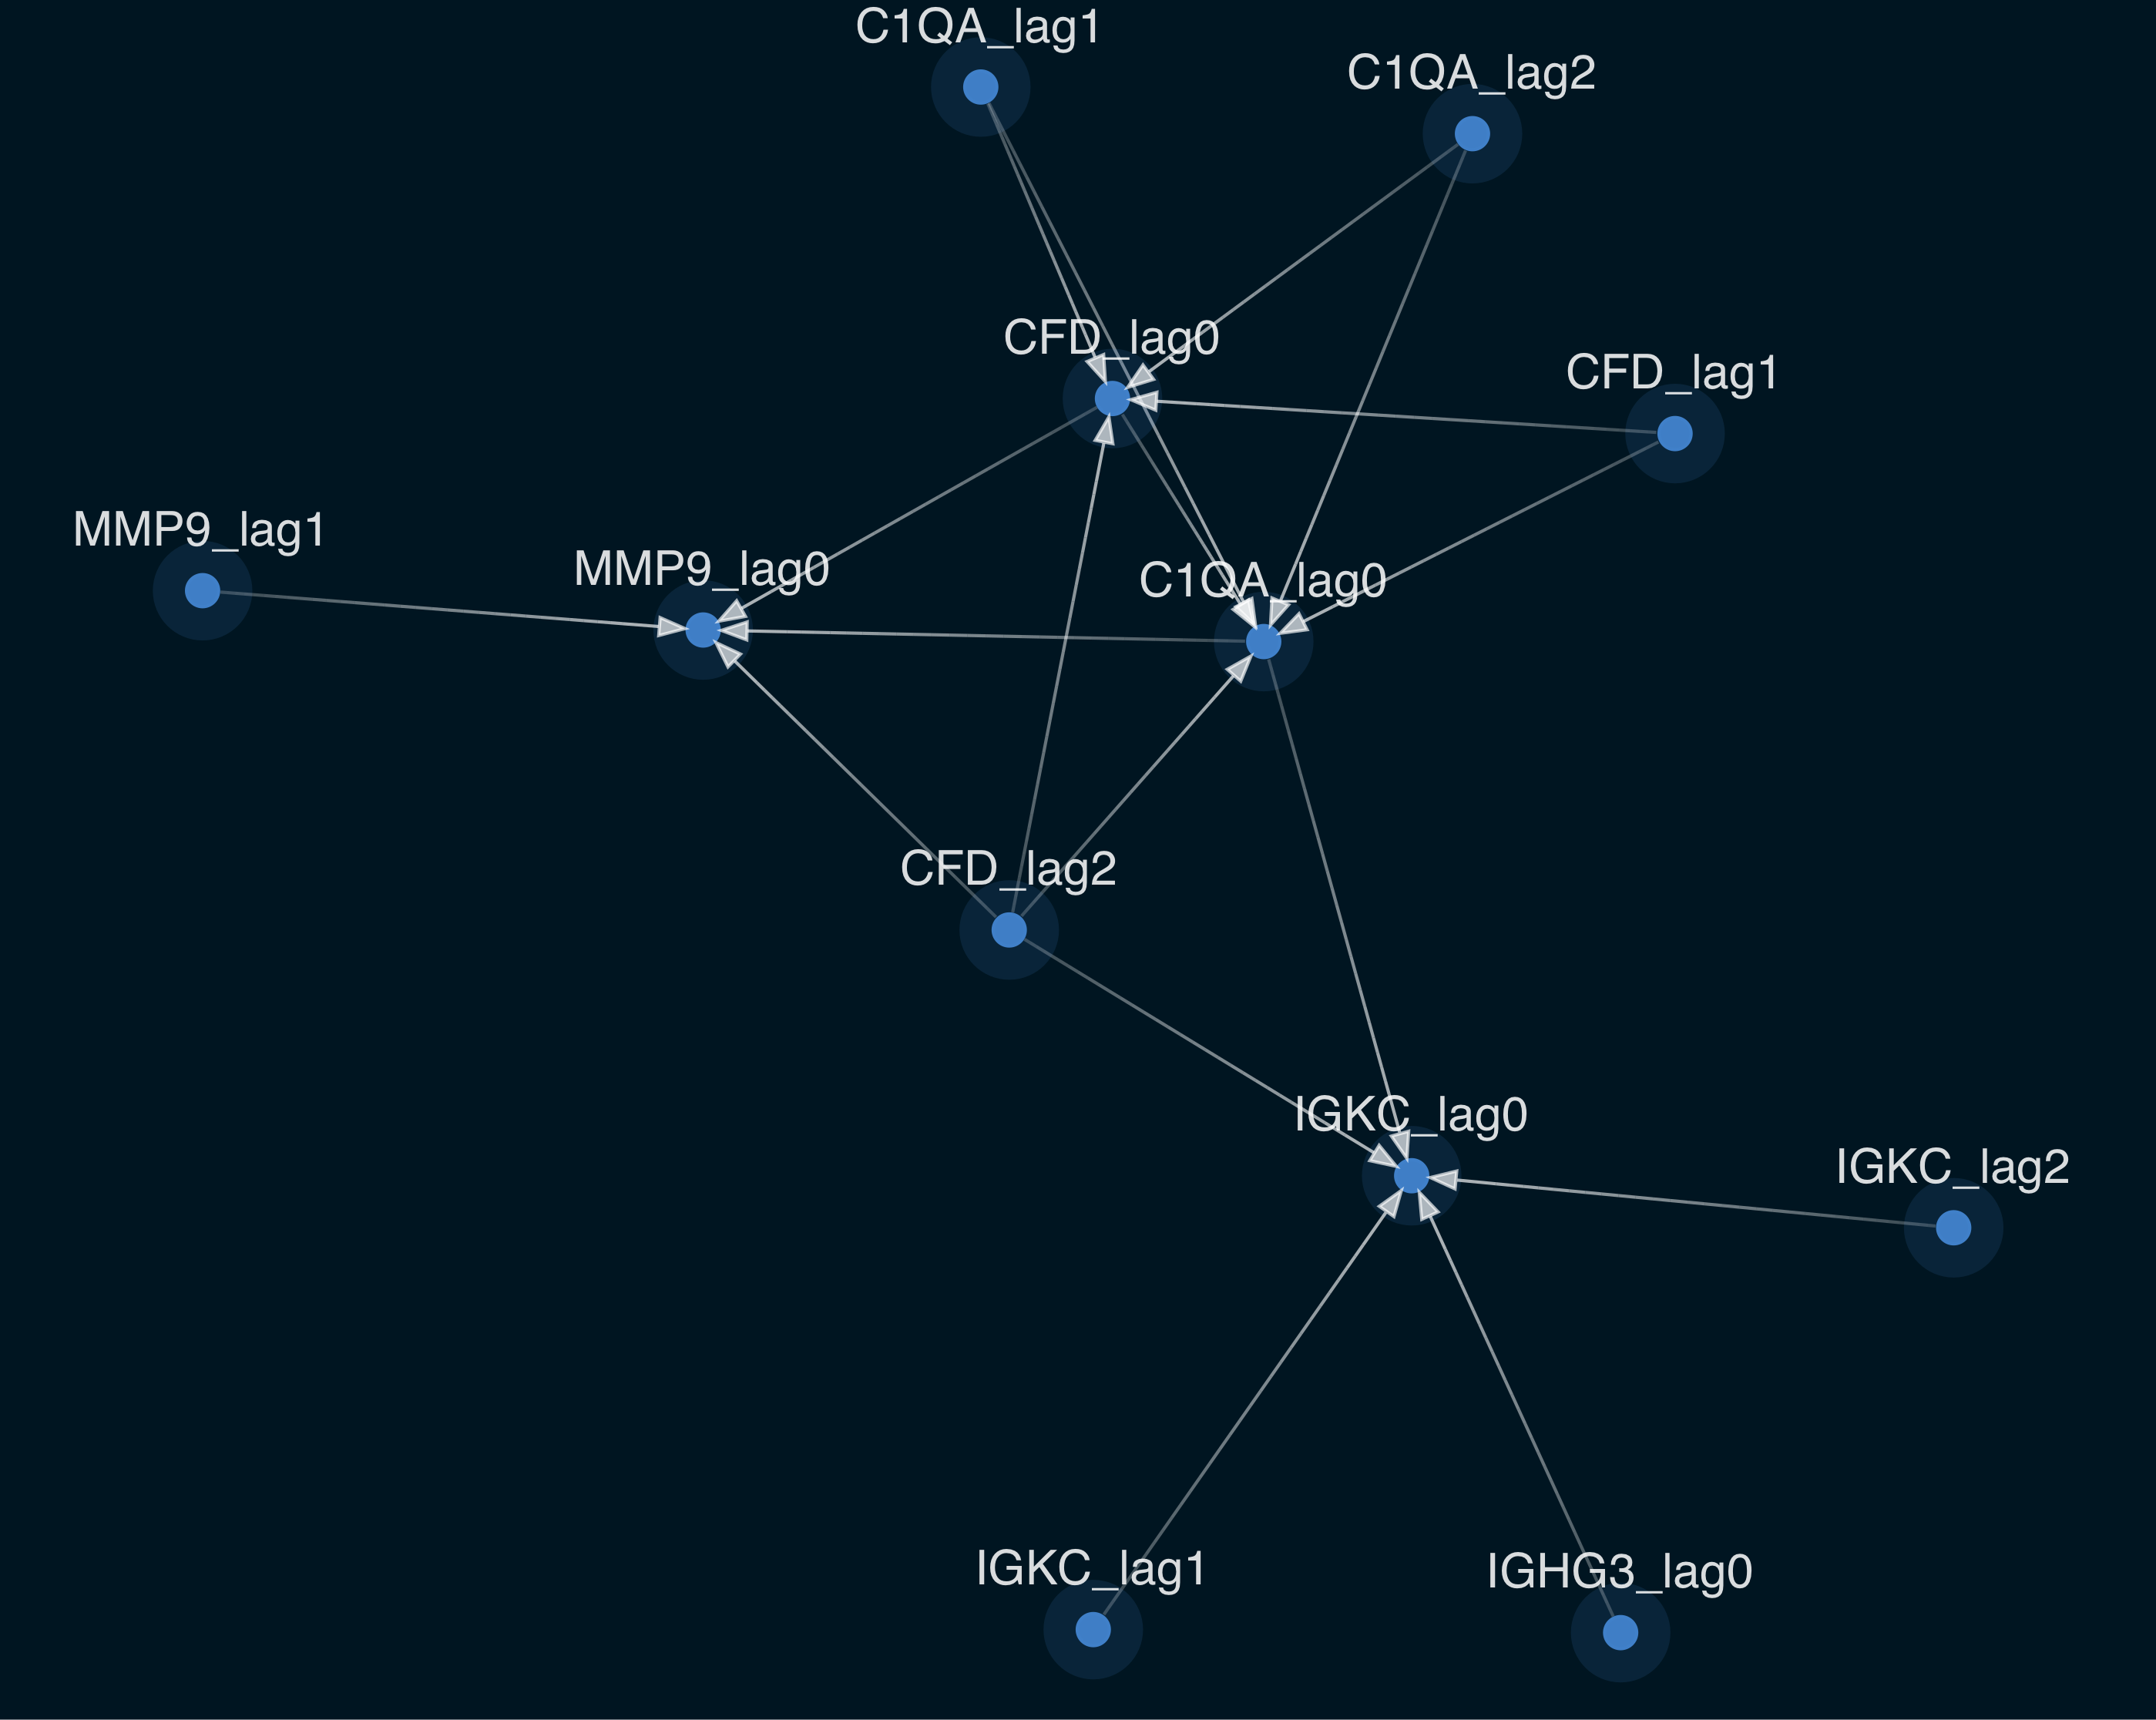

In [250]:
from IPython.display import Image
W_cleaned = utils.largest_subgraph(W_dy)
img = figures.visualize_dbn(W_cleaned, savepath='../figures/dbnviz.png')
Image(img)

In [157]:
# test significance
n = 25
null_Ws = []
mses = np.zeros(n)
for i in range(n):
    train_barcodes = time_barcodes[train_idx]
    random.shuffle(train_barcodes)
    random_df = make_df(train_barcodes)
    random_W = utils.learn_dbn(random_df, lags)
    null_Ws.append(random_W)
    random_mse = utils.mse(random_W, test_df, lags)
    mses[i] = random_mse
true_mse, mses

(0.11788088997100157,
 array([0.12042969, 0.12023376, 0.11991364, 0.12040497, 0.12037504,
        0.12001611, 0.12120678, 0.12094752, 0.11977286, 0.12030436,
        0.12014758, 0.12048858, 0.12058002, 0.12044474, 0.12092256,
        0.12016134, 0.12083397, 0.12119782, 0.12056435, 0.12053972,
        0.12056957, 0.12024636, 0.12119847, 0.12121917, 0.12086192]))

In [158]:
(true_mse - np.mean(mses))/ np.std(mses)

-6.546321497950642

In [159]:
np.mean(mses)

0.12054323612104981

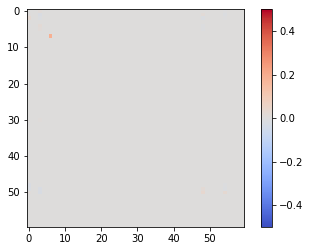

CPB1_lag1 --> CPB1_lag0, perturbation: (0.19, 0.1878114487625535)


In [161]:
W_adj = utils.adjacency_matrix(W_dy)
total_perturb = np.zeros(W_adj.shape)
for null_W in null_Ws:
    total_perturb += W_adj - utils.adjacency_matrix(null_W)
total_perturb /= len(null_Ws)
    
plt.imshow(total_perturb, cmap='coolwarm', vmin=-.5, vmax=.5)
plt.colorbar()
plt.show()

perturbed = np.argwhere(np.abs(total_perturb) > .1)
nodes = list(W_dy.nodes)
for p_i, c_i in perturbed:
    print(f'{nodes[p_i]} --> {nodes[c_i]}, perturbation: {round(total_perturb[p_i,c_i], 2), W_adj[p_i,c_i]}')

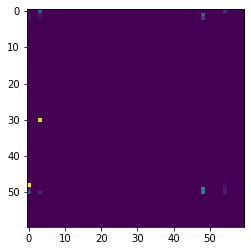

In [160]:
plt.imshow(utils.adjacency_matrix(null_Ws[0]))

In [237]:
# Test MSE over training size
half = len(time_barcodes)//2
test_barcodes = time_barcodes[0:100]
pcts = np.linspace(0.1,0.9,20)
mses = []
for pct in pcts:
    train_idx = np.zeros(len(times))
    pct_i = int(len(times) * pct)
    print(len(times), pct_i)
    train_idx[:pct_i] = 1
    train_idx = train_idx.astype(bool)
#     test_idx = np.copy(train_idx)
#     test_idx[pct_i:pct_i+100]

    train_barcodes = time_barcodes[train_idx]
#     test_barcodes = time_barcodes[test_idx]
    pct_df = make_df(train_barcodes)
    pct_test_df = make_df(test_barcodes)
    pct_W = utils.learn_dbn(pct_df, lags)
    pct_mse = utils.mse(pct_W, pct_test_df, lags)
    mses.append(pct_mse)

2889 288
2889 410
2889 532
2889 653
2889 775
2889 897
2889 1018
2889 1140
2889 1262
2889 1383
2889 1505
2889 1626
2889 1748
2889 1870
2889 1991
2889 2113
2889 2235
2889 2356
2889 2478
2889 2600


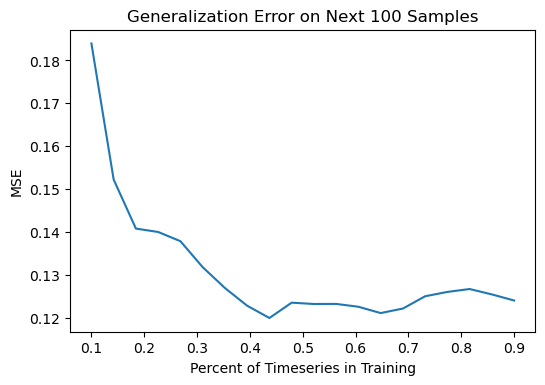

In [242]:
# final_100 = np.copy(mses)
plt.figure(dpi=100)
plt.plot(pcts, next_100)
plt.title('Generalization Error on Next 100 Samples')
plt.xlabel('Percent of Timeseries in Training')
plt.ylabel('MSE')
# plt.plot(pcts, final_100)
plt.savefig('../figures/next100.png', dpi=300)
plt.show()

In [234]:
final_100

array([0.08530384, 0.08513337, 0.08507604, 0.08503551, 0.0851138 ,
       0.08518466, 0.08514644, 0.08513241, 0.08503708, 0.08502893,
       0.08500549, 0.08491253, 0.08484951, 0.08490563, 0.08484628,
       0.08445805, 0.08424944, 0.08420113, 0.08415206, 0.08419296])

In [193]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

times.sort()
dim_df = make_df(time_barcodes)

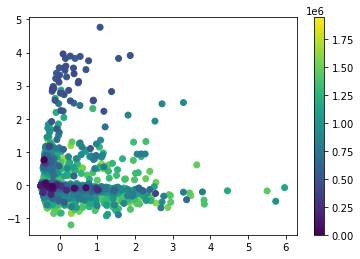

In [212]:
pca = PCA(n_components=5)
pca_samples = pca.fit_transform(dim_df.values)
plt.scatter(pca_samples[:,0][::-1], pca_samples[:,2][::-1], c=times[::-1])
# plt.scatter(pca_samples[:,0], pca_samples[:,2], c=times)

plt.colorbar()
plt.show()

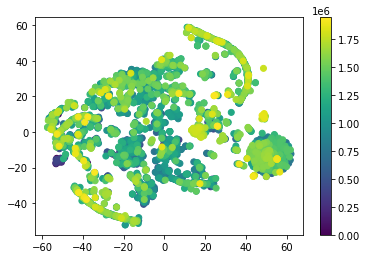

In [198]:
tsne = TSNE(n_components=2)
tsne_samples = tsne.fit_transform(dim_df.values)
plt.scatter(tsne_samples[:,0][::-1], tsne_samples[:,1][::-1], c=times)
plt.colorbar()
plt.show()